In [1]:
#Set up
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

In [2]:
#Load the data
#Understand the data_identification first
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

In [3]:
print(data_identification.head())

   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train


In [4]:
print(data_identification.isnull().sum())

tweet_id          0
identification    0
dtype: int64


In [5]:
print(data_identification.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867535 entries, 0 to 1867534
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tweet_id        object
 1   identification  object
dtypes: object(2)
memory usage: 28.5+ MB
None


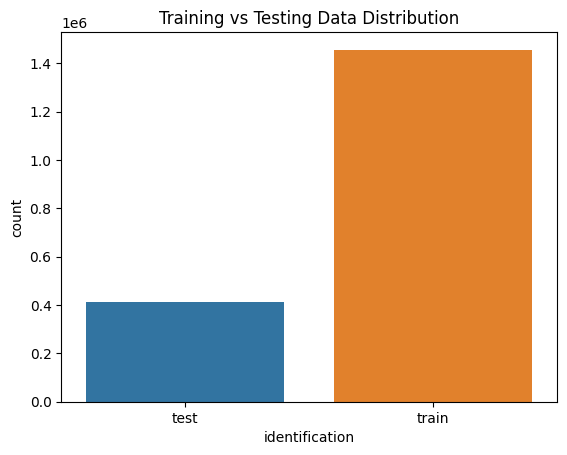

In [6]:
#Check the distribution
sns.countplot(data=data_identification, x='identification')
plt.title("Training vs Testing Data Distribution")
plt.show()

In [7]:
print(f"Number of duplicate tweet_id: {data_identification['tweet_id'].duplicated().sum()}")

Number of duplicate tweet_id: 0


In [8]:
#Next is tweets_DM
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 4:  # Print first 5 lines
            break

{"_score": 391, "_index": "hashtag_tweets", "_source": {"tweet": {"hashtags": ["Snapchat"], "tweet_id": "0x376b20", "text": "People who post \"add me on #Snapchat\" must be dehydrated. Cuz man.... that's <LH>"}}, "_crawldate": "2015-05-23 11:42:47", "_type": "tweets"}
{"_score": 433, "_index": "hashtag_tweets", "_source": {"tweet": {"hashtags": ["freepress", "TrumpLegacy", "CNN"], "tweet_id": "0x2d5350", "text": "@brianklaas As we see, Trump is dangerous to #freepress around the world. What a <LH> <LH> #TrumpLegacy.  #CNN"}}, "_crawldate": "2016-01-28 04:52:09", "_type": "tweets"}
{"_score": 232, "_index": "hashtag_tweets", "_source": {"tweet": {"hashtags": ["bibleverse"], "tweet_id": "0x28b412", "text": "Confident of your obedience, I write to you, knowing that you will do even more than I ask. (Philemon 1:21) 3/4 #bibleverse <LH> <LH>"}}, "_crawldate": "2017-12-25 04:39:20", "_type": "tweets"}
{"_score": 376, "_index": "hashtag_tweets", "_source": {"tweet": {"hashtags": [], "tweet_id

In [9]:
#Convert to dataframe
import json
import pandas as pd

tweets = []

with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data = json.loads(line.strip())  
        tweet_id = data["_source"]["tweet"]["tweet_id"]
        text = data["_source"]["tweet"]["text"]
        tweets.append({"tweet_id": tweet_id, "text": text})


tweets_df = pd.DataFrame(tweets)

print(tweets_df.head())

   tweet_id                                               text
0  0x376b20  People who post "add me on #Snapchat" must be ...
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2  0x28b412  Confident of your obedience, I write to you, k...
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4  0x2de201  "Trust is not the same as faith. A friend is s...


In [10]:
#emotion.csv
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')

In [11]:
print(emotion.head())
print(emotion.info())

   tweet_id       emotion
0  0x3140b1       sadness
1  0x368b73       disgust
2  0x296183  anticipation
3  0x2bd6e1           joy
4  0x2ee1dd  anticipation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455563 entries, 0 to 1455562
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   tweet_id  1455563 non-null  object
 1   emotion   1455563 non-null  object
dtypes: object(2)
memory usage: 22.2+ MB
None


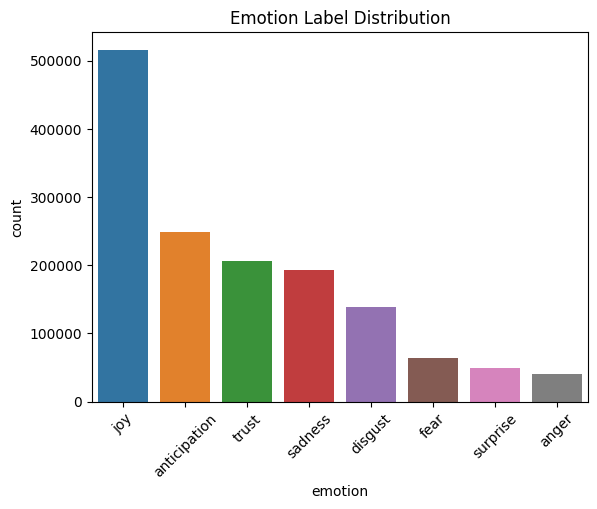

In [12]:
#Check the distribution
sns.countplot(data=emotion, x='emotion', order=emotion['emotion'].value_counts().index)
plt.title("Emotion Label Distribution")
plt.xticks(rotation=45)
plt.show()

In [13]:
print(f"Number of missing tweet_id: {emotion['tweet_id'].isnull().sum()}")
print(f"Number of duplicate tweet_id: {emotion['tweet_id'].duplicated().sum()}")

Number of missing tweet_id: 0
Number of duplicate tweet_id: 0


In [14]:
# Combine data_identification.csv and tweets_DM.json
tweets_df = pd.DataFrame(tweets)
merged_data = pd.merge(data_identification, tweets_df, on='tweet_id', how='left')  # Merge using tweet_id

print(merged_data.head())

   tweet_id identification                                               text
0  0x28cc61           test  @Habbo I've seen two separate colours of the e...
1  0x29e452          train  Huge Respect🖒 @JohnnyVegasReal talking about l...
2  0x2b3819          train  Yoooo we hit all our monthly goals with the ne...
3  0x2db41f           test  @FoxNews @KellyannePolls No serious self respe...
4  0x2a2acc          train  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...


In [15]:
#Add emotion labels to training data
train_data = pd.merge(merged_data[merged_data['identification'] == 'train'], emotion, on='tweet_id', how='left')
test_data = merged_data[merged_data['identification'] == 'test']

In [16]:
print(train_data.head())
print(test_data.head())

   tweet_id identification                                               text  \
0  0x29e452          train  Huge Respect🖒 @JohnnyVegasReal talking about l...   
1  0x2b3819          train  Yoooo we hit all our monthly goals with the ne...   
2  0x2a2acc          train  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...   
3  0x2a8830          train  Come join @ambushman27 on #PUBG while he striv...   
4  0x20b21d          train  @fanshixieen2014 Blessings!My #strength little...   

        emotion  
0           joy  
1           joy  
2         trust  
3           joy  
4  anticipation  
    tweet_id identification                                               text
0   0x28cc61           test  @Habbo I've seen two separate colours of the e...
3   0x2db41f           test  @FoxNews @KellyannePolls No serious self respe...
15  0x2466f6           test  Looking for a new car, and it says 1 lady owne...
23  0x23f9e9           test  @cineworld “only the brave” just out and fount...
31  0x1fb4

In [17]:
#Text Preprocessing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'<lh>', '', text)  # Remove <LH> placeholders
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)


In [18]:
train_data = train_data.copy()  
test_data = test_data.copy() 

train_data.loc[:, 'cleaned_text'] = train_data['text'].apply(clean_text)
test_data.loc[:, 'cleaned_text'] = test_data['text'].apply(clean_text)

In [19]:
print(train_data[['text', 'cleaned_text']].head())
print(test_data[['text', 'cleaned_text']].head())

                                                text  \
0  Huge Respect🖒 @JohnnyVegasReal talking about l...   
1  Yoooo we hit all our monthly goals with the ne...   
2  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...   
3  Come join @ambushman27 on #PUBG while he striv...   
4  @fanshixieen2014 Blessings!My #strength little...   

                                        cleaned_text  
0  huge respect talking losing dad cancerif dont ...  
1          yoooo hit monthly goals new app two weeks  
2                           well done team every one  
3                  come join strives chicken donners  
4  blessingsmy little brittledoor open wont go no...  
                                                 text  \
0   @Habbo I've seen two separate colours of the e...   
3   @FoxNews @KellyannePolls No serious self respe...   
15  Looking for a new car, and it says 1 lady owne...   
23  @cineworld “only the brave” just out and fount...   
31  Felt like total dog 💩 going into open gym an

In [20]:
#Most frequent label is "joy," while "anger" is the least frequent.
#This imbalance could affect model training and evaluation.

from sklearn.utils import resample

# Get the majority class
majority = train_data[train_data['emotion'] == 'joy']

# Set a target size for oversampling
target_size = int(len(majority) * 0.75)  # 75% of the majority class size

balanced_data = [majority]

for emotion in train_data['emotion'].unique():
    if emotion != 'joy':
        minority = train_data[train_data['emotion'] == emotion]
        oversampled_minority = resample(minority, 
                                        replace=True, 
                                        n_samples=min(target_size, len(majority)),  # Cap size
                                        random_state=42)
        balanced_data.append(oversampled_minority)

train_data_balanced = pd.concat(balanced_data)

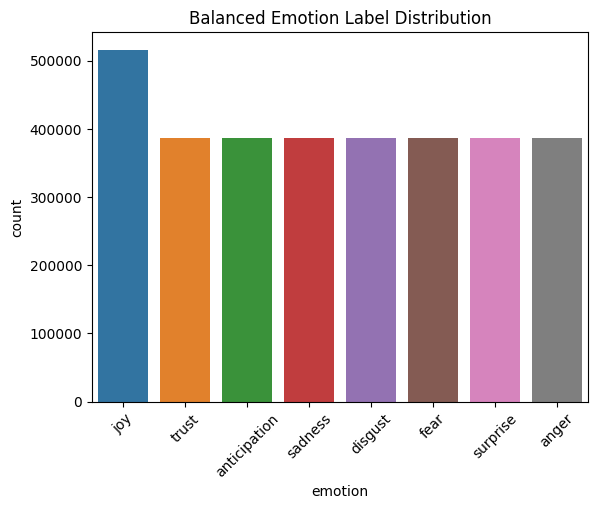

In [21]:
# Check new label distribution
sns.countplot(data=train_data_balanced, x='emotion', order=train_data_balanced['emotion'].value_counts().index)
plt.title("Balanced Emotion Label Distribution")
plt.xticks(rotation=45)
plt.show()

In [22]:
#try use SMOTE for synthetic data
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 1), max_df=0.8, min_df=5)
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
y_train = train_data['emotion']

In [23]:
# Inspect the shape of the feature matrix
print("TF-IDF matrix shape:", X_train.shape)

TF-IDF matrix shape: (1455563, 500)


In [24]:
# Subset a smaller portion of the dataset for testing becasue of computional limitation
train_sample = train_data_balanced.sample(frac=0.2, random_state=42)
X_sample = vectorizer.transform(train_sample['cleaned_text'])
y_sample = train_sample['emotion']

# Apply SMOTE on the subset
smote = SMOTE(random_state=42)
X_sample_smote, y_sample_smote = smote.fit_resample(X_sample, y_sample)

print("Subset SMOTE label distribution:", Counter(y_sample_smote))


Subset SMOTE label distribution: Counter({'trust': 103169, 'fear': 103169, 'surprise': 103169, 'joy': 103169, 'sadness': 103169, 'anticipation': 103169, 'disgust': 103169, 'anger': 103169})


In [25]:
print("Shape of resampled data:", X_sample_smote.shape)
print("First 5 resampled labels:", y_sample_smote[:5])


Shape of resampled data: (825352, 500)
First 5 resampled labels: 0       trust
1        fear
2    surprise
3         joy
4         joy
Name: emotion, dtype: object


In [26]:
#Split the balanced subset into training and validation sets 
from sklearn.model_selection import train_test_split

# Split data
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_sample_smote, y_sample_smote, test_size=0.2, random_state=42
)

print("Training set shape:", X_train_split.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (660281, 500)
Validation set shape: (165071, 500)


In [27]:
#Train the baseline logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_split, y_train_split)

# Predict on validation set
y_val_pred = model.predict(X_val)

In [28]:
print(classification_report(y_val, y_val_pred))
print("Macro F1 Score:", f1_score(y_val, y_val_pred, average='macro'))

              precision    recall  f1-score   support

       anger       0.26      0.30      0.28     20784
anticipation       0.37      0.39      0.38     20720
     disgust       0.24      0.20      0.22     20650
        fear       0.35      0.34      0.34     20429
         joy       0.33      0.24      0.27     20765
     sadness       0.27      0.19      0.23     20468
    surprise       0.20      0.33      0.25     20619
       trust       0.32      0.30      0.31     20636

    accuracy                           0.29    165071
   macro avg       0.29      0.29      0.29    165071
weighted avg       0.29      0.29      0.29    165071

Macro F1 Score: 0.28551043002356546


In [29]:
#optimize parameters to capture more meaningful features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), max_df=0.9, min_df=5)
X_train = vectorizer.fit_transform(train_data_balanced['cleaned_text'])
X_val = vectorizer.transform(test_data['cleaned_text'])

print("TF-IDF matrix shape:", X_train.shape)


TF-IDF matrix shape: (3225101, 2000)


In [30]:
# Logistic regression with class weights
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

classes = train_data_balanced['emotion'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=train_data_balanced['emotion'])
class_weights_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {'joy': 0.7812487282395735, 'trust': 1.0416669896540676, 'anticipation': 1.0416669896540676, 'sadness': 1.0416669896540676, 'disgust': 1.0416669896540676, 'fear': 1.0416669896540676, 'surprise': 1.0416669896540676, 'anger': 1.0416669896540676}


In [31]:
# Split training and validation sets
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, train_data_balanced['emotion'], test_size=0.2, random_state=42)

In [32]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight=class_weights_dict, random_state=42)
model.fit(X_train_split, y_train_split)

LogisticRegression(class_weight={'anger': 1.0416669896540676,
                                 'anticipation': 1.0416669896540676,
                                 'disgust': 1.0416669896540676,
                                 'fear': 1.0416669896540676,
                                 'joy': 0.7812487282395735,
                                 'sadness': 1.0416669896540676,
                                 'surprise': 1.0416669896540676,
                                 'trust': 1.0416669896540676},
                   max_iter=1000, random_state=42)

In [33]:
y_val_pred = model.predict(X_val_split)
print(classification_report(y_val_split, y_val_pred))
print("Macro F1 Score:", f1_score(y_val_split, y_val_pred, average='macro'))

              precision    recall  f1-score   support

       anger       0.37      0.44      0.40     77448
anticipation       0.41      0.46      0.43     77113
     disgust       0.29      0.30      0.29     77404
        fear       0.36      0.48      0.41     77500
         joy       0.42      0.31      0.35    103170
     sadness       0.31      0.24      0.27     77646
    surprise       0.34      0.30      0.32     77264
       trust       0.35      0.34      0.34     77476

    accuracy                           0.36    645021
   macro avg       0.35      0.36      0.35    645021
weighted avg       0.36      0.36      0.35    645021

Macro F1 Score: 0.3528236089987873


In [34]:
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Transform test data into feature matrix using the same TF-IDF vectorizer
X_test = vectorizer.transform(test_data['cleaned_text'])

In [35]:
# Predict emotions for the test set
y_test_pred = model.predict(X_test)